### Imports

In [ ]:
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb

from sklearn.metrics import mean_squared_error

### Data Ingest

In [ ]:
df = pd.read_csv('/data (1).csv')
#df.columns = ['timestamp', 'cpu_request']
#df['time'] = pd.to_datetime(df['time'])

print(df.shape)
print(df.columns)
display(df.head(3))
display(df.tail(3))

(4999, 2)
Index(['timestamp', 'cpu_request'], dtype='object')


,timestamp,cpu_request
0,01-05-2019 19:00,0.25000
1,01-05-2019 19:01,0.32809
2,01-05-2019 19:02,0.23744


,timestamp,cpu_request
4996,05-05-2019 06:16,0.269385
4997,05-05-2019 06:17,0.137486
4998,05-05-2019 06:18,0.177800


### Basic Visualization

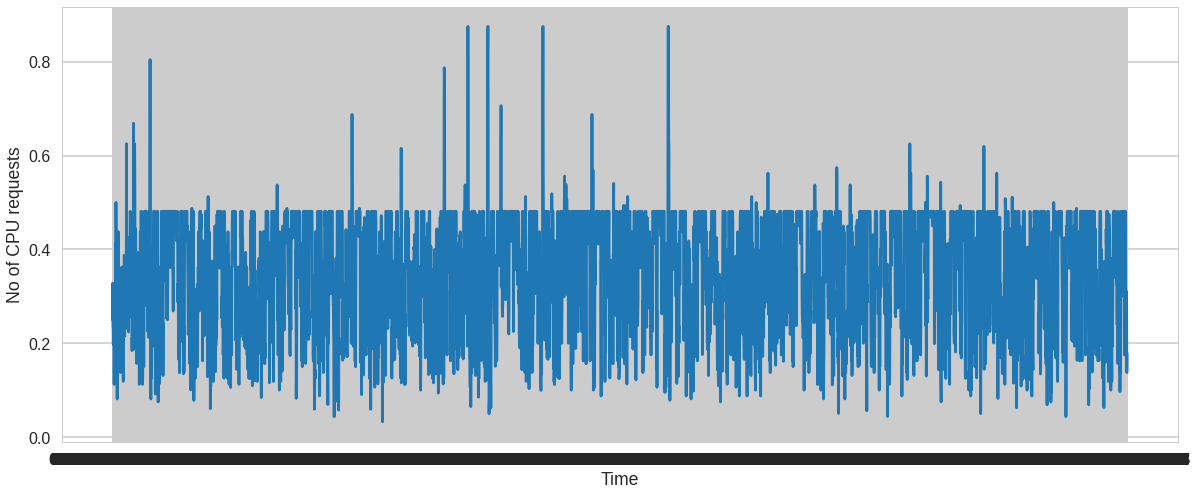

In [ ]:
plt.figure(figsize=(20,8))
plt.style.use('seaborn-poster')
plt.style.use('seaborn-whitegrid')
plt.plot(df['timestamp'], df['cpu_request']); 
plt.xlabel('Time');
plt.ylabel('No of CPU requests');

### Train and Test Data Creation

In [ ]:
#df_train = df.loc[pd.to_datetime('1749-01-31'):pd.to_datetime('1929-12-31')]
#df_train = df.loc['1749-01-31':'1929-12-31']
df_train = df.loc[0:803]
df_train = df_train.reset_index(drop=True)
df_test = df.loc[804:1691]
df_test = df_test.reset_index(drop=True)
print(df.shape, df_train.shape, df_test.shape)

(4999, 2) (804, 2) (888, 2)


In [ ]:
display(df_train.head(3))
display(df_train.tail(3))
display(df_test.head(3))
display(df_test.tail(3))

,timestamp,cpu_request
0,01-05-2019 19:00,0.25000
1,01-05-2019 19:01,0.32809
2,01-05-2019 19:02,0.23744


,timestamp,cpu_request
801,02-05-2019 08:21,0.48111
802,02-05-2019 08:22,0.48111
803,02-05-2019 08:23,0.48111


,timestamp,cpu_request
0,02-05-2019 08:24,0.48111
1,02-05-2019 08:25,0.48111
2,02-05-2019 08:26,0.48111


,timestamp,cpu_request
885,02-05-2019 23:09,0.48111
886,02-05-2019 23:10,0.48111
887,02-05-2019 23:11,0.42800


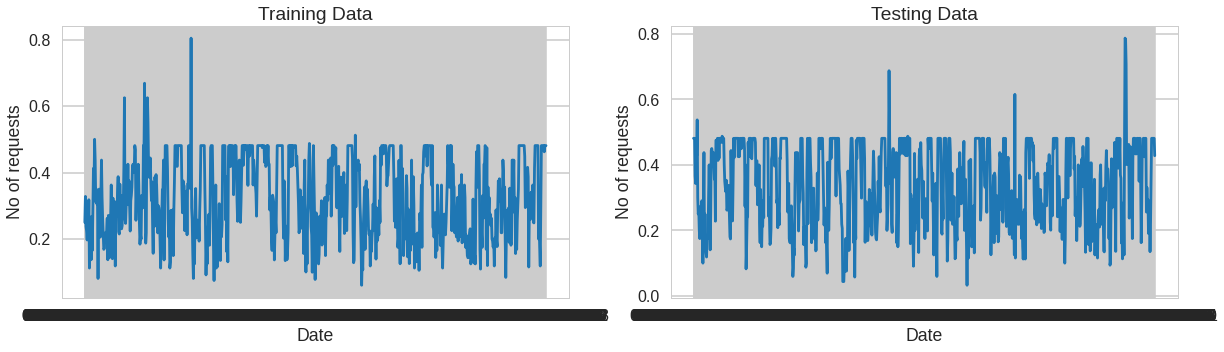

In [ ]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(df_train['timestamp'], df_train['cpu_request'])
plt.xlabel('Date')
plt.ylabel('No of requests')
plt.title('Training Data')

plt.subplot(1,2,2)
plt.plot(df_test['timestamp'], df_test['cpu_request'])
plt.xlabel('Date')
plt.ylabel('No of requests')
plt.title('Testing Data');

In [ ]:
from pandas import DataFrame
from pandas import concat
 
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [ ]:
data_train = series_to_supervised(df_train['cpu_request'].to_list(), 100, 1) # 500 # 20
data_test = series_to_supervised(df_test['cpu_request'].to_list(), 100, 1)
print(data_train.shape, data_test.shape)

(704, 101) (788, 101)


In [ ]:
df_train_y = data_train['var1(t)']
df_train_X = data_train.drop(columns=['var1(t)'])
df_test_y = data_test['var1(t)']
df_test_X = data_test.drop(columns=['var1(t)'])

X_train = df_train_X.values
y_train = df_train_y.values
X_test = df_test_X.values
y_test = df_test_y.values

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Train and Evaluate a Baseline Reference Model



In [ ]:
X_test

array([[0.48111  , 0.48111  , 0.48111  , ..., 0.48111  , 0.44986  ,
        0.273198 ],
       [0.48111  , 0.48111  , 0.365548 , ..., 0.44986  , 0.273198 ,
        0.39999  ],
       [0.48111  , 0.365548 , 0.34309  , ..., 0.273198 , 0.39999  ,
        0.0824674],
       ...,
       [0.21875  , 0.316649 , 0.326049 , ..., 0.48111  , 0.48111  ,
        0.48111  ],
       [0.316649 , 0.326049 , 0.227498 , ..., 0.48111  , 0.48111  ,
        0.48111  ],
       [0.326049 , 0.227498 , 0.13746  , ..., 0.48111  , 0.48111  ,
        0.48111  ]])

In [ ]:
df_test_X.head(3)
df_test_X.columns

Index(['var1(t-100)', 'var1(t-99)', 'var1(t-98)', 'var1(t-97)', 'var1(t-96)',
       'var1(t-95)', 'var1(t-94)', 'var1(t-93)', 'var1(t-92)', 'var1(t-91)',
       'var1(t-90)', 'var1(t-89)', 'var1(t-88)', 'var1(t-87)', 'var1(t-86)',
       'var1(t-85)', 'var1(t-84)', 'var1(t-83)', 'var1(t-82)', 'var1(t-81)',
       'var1(t-80)', 'var1(t-79)', 'var1(t-78)', 'var1(t-77)', 'var1(t-76)',
       'var1(t-75)', 'var1(t-74)', 'var1(t-73)', 'var1(t-72)', 'var1(t-71)',
       'var1(t-70)', 'var1(t-69)', 'var1(t-68)', 'var1(t-67)', 'var1(t-66)',
       'var1(t-65)', 'var1(t-64)', 'var1(t-63)', 'var1(t-62)', 'var1(t-61)',
       'var1(t-60)', 'var1(t-59)', 'var1(t-58)', 'var1(t-57)', 'var1(t-56)',
       'var1(t-55)', 'var1(t-54)', 'var1(t-53)', 'var1(t-52)', 'var1(t-51)',
       'var1(t-50)', 'var1(t-49)', 'var1(t-48)', 'var1(t-47)', 'var1(t-46)',
       'var1(t-45)', 'var1(t-44)', 'var1(t-43)', 'var1(t-42)', 'var1(t-41)',
       'var1(t-40)', 'var1(t-39)', 'var1(t-38)', 'var1(t-37)', 'var1(t-36)'

In [ ]:
df_test_X['var1(t-1)'].values

array([0.273198 , 0.39999  , 0.0824674, 0.143706 , 0.23744  , 0.24065  ,
       0.46865  , 0.42488  , 0.48111  , 0.48111  , 0.48111  , 0.48111  ,
       0.42488  , 0.41865  , 0.47488  , 0.48111  , 0.48111  , 0.48111  ,
       0.48111  , 0.48111  , 0.46865  , 0.33686  , 0.41248  , 0.41248  ,
       0.278129 , 0.334399 , 0.28127  , 0.39999  , 0.22441  , 0.16246  ,
       0.32497  , 0.23742  , 0.149929 , 0.231229 , 0.212496 , 0.29062  ,
       0.239436 , 0.48111  , 0.48111  , 0.48111  , 0.48111  , 0.48111  ,
       0.48111  , 0.48111  , 0.48111  , 0.24366  , 0.29998  , 0.2375   ,
       0.1569   , 0.16318  , 0.20624  , 0.41751  , 0.428    , 0.48111  ,
       0.428    , 0.42123  , 0.48111  , 0.3962   , 0.48111  , 0.48111  ,
       0.41861  , 0.28432  , 0.29372  , 0.20815  , 0.26915  , 0.24849  ,
       0.21748  , 0.42177  , 0.419018 , 0.48111  , 0.48111  , 0.48111  ,
       0.48111  , 0.48111  , 0.48111  , 0.48111  , 0.48111  , 0.48111  ,
       0.48111  , 0.48111  , 0.48111  , 0.41183  , 

In [ ]:
predictions = pd.DataFrame(y_test)

y_pred_baseline = df_test_X['var1(t-1)'].values
predictions['baseline'] = y_pred_baseline

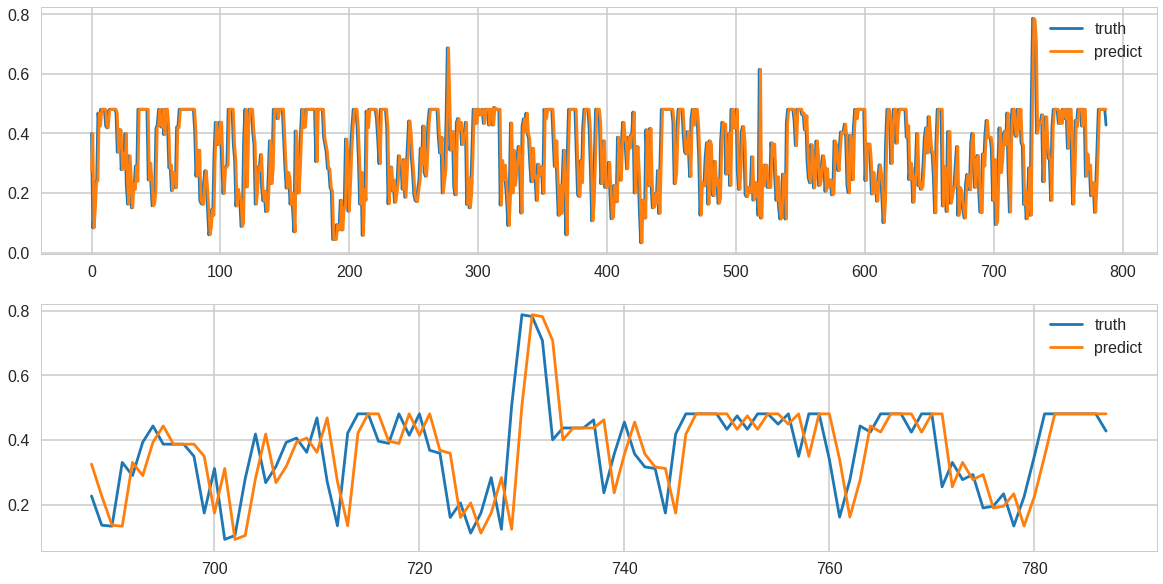

In [ ]:
# make a simple function for this, comparing truth to predictions
plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
#plt.plot(predictions[0][0:100])
plt.plot(predictions[0], label='truth')
plt.plot(predictions['baseline'], label='predict')
plt.legend()

plt.subplot(2,1,2)
plt.plot(predictions[0].tail(100), label='truth')
plt.plot(predictions['baseline'].tail(100), label='predict')
plt.legend()

In [ ]:
mean_squared_error(y_test, y_pred_baseline) 

0.00039252645491878176

### Train and Evaluate a Gradient Boosted Regressor Model

We set the number of trees (n_estimators) and the maximum depth of a given tree in the ensemble (max_depth) by hand and train a gradient boosted tree regression model from the scikit-learn library. 

In [ ]:
# hyperparameters 100 5
N_ESTIMATORS = 10
MAX_DEPTH = 3

# create model
mid_model = GradientBoostingRegressor(loss="ls", n_estimators=N_ESTIMATORS, max_depth=MAX_DEPTH)

# train model
mid_model.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:290: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  FutureWarning,


GradientBoostingRegressor(loss='ls', n_estimators=10)

In [ ]:
# model evaluation

predictions = pd.DataFrame(y_test)
y_pred = mid_model.predict(X_test)
predictions['mid'] = y_pred
predictions.head()

,0,mid
0,0.399990,0.290874
1,0.082467,0.331138
2,0.143706,0.285438
3,0.237440,0.282643
4,0.240650,0.281252


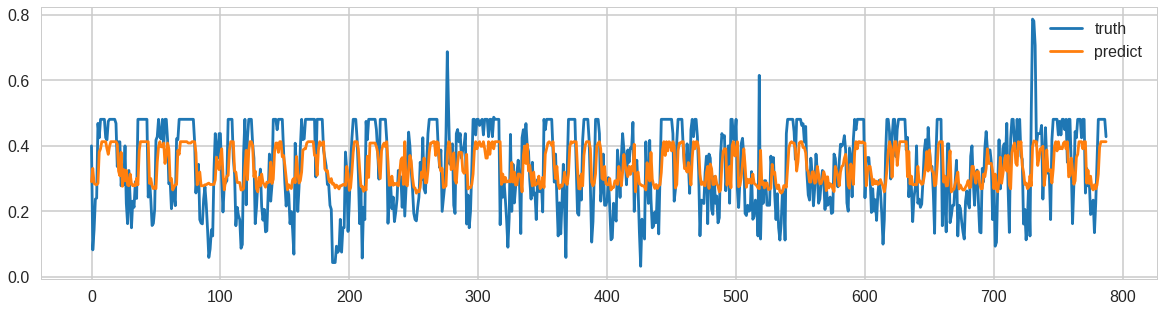

In [ ]:
plt.figure(figsize=(20,5))
#plt.plot(predictions[0][0:100])
plt.plot(predictions[0], label='truth')
plt.plot(predictions['mid'], label='predict')
plt.legend()

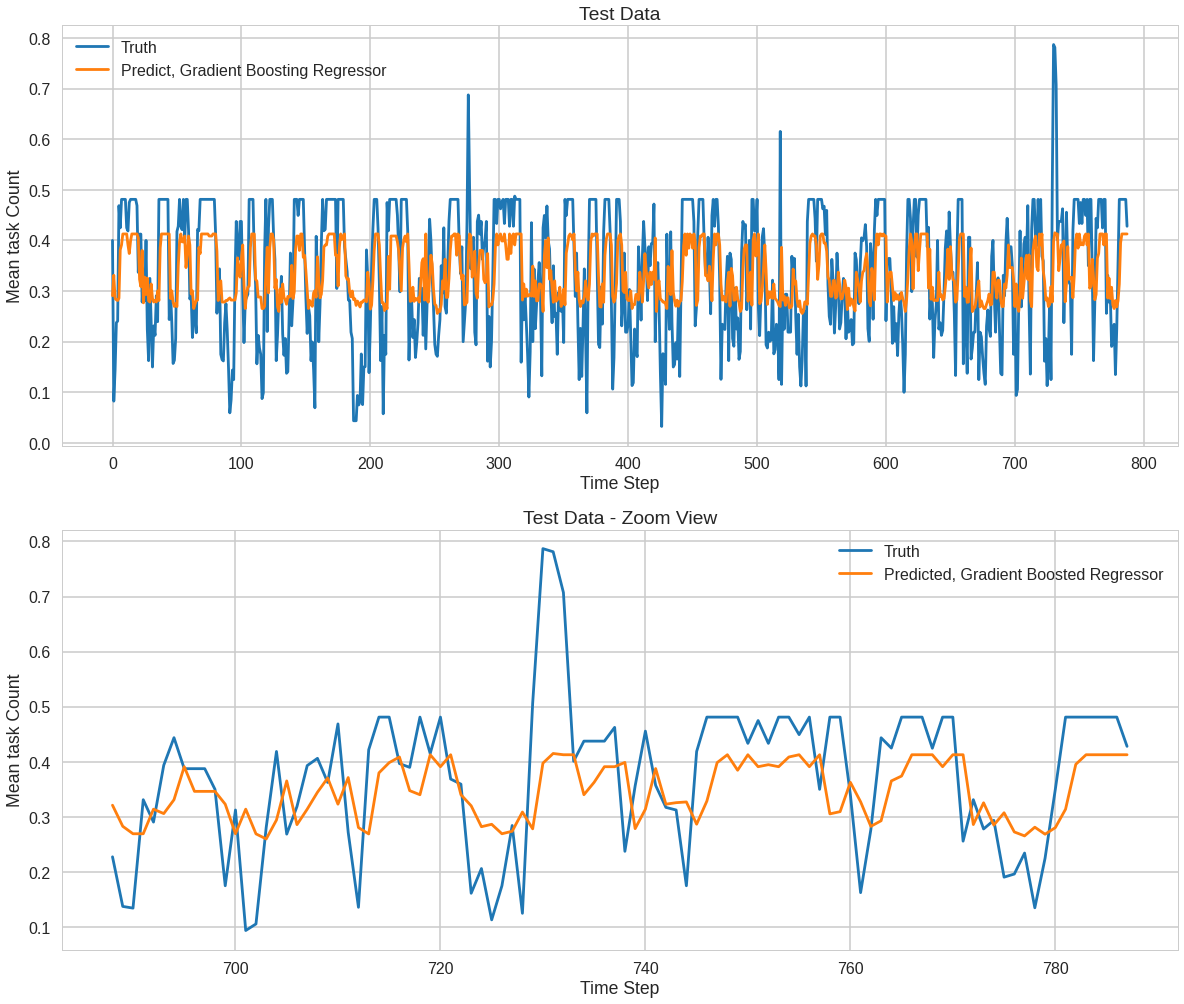

In [ ]:
# make a simple function for this, comparing truth to predictions
plt.figure(figsize=(20,17))
plt.style.use('seaborn-poster')
plt.subplot(2,1,1)
#plt.plot(predictions[0][0:100])
plt.plot(predictions[0], label='Truth')
plt.plot(predictions['mid'], label='Predict, Gradient Boosting Regressor')
plt.ylabel('Mean task Count')
plt.xlabel('Time Step')
plt.title('Test Data')
plt.legend()

plt.subplot(2,1,2)
plt.plot(predictions[0].tail(100), label='Truth')
plt.plot(predictions['mid'].tail(100), label='Predicted, Gradient Boosted Regressor')
plt.ylabel('Mean task Count')
plt.xlabel('Time Step')
plt.title('Test Data - Zoom View')
plt.legend();

In [ ]:
# mean_squared_error(y_true, y_pred)
mean_squared_error(y_test, y_pred) 

# note: need to have a baseline to beat . . . see chollet baselines!

0.010032252442172632

In [ ]:
#Root mean squared error
from sklearn.metrics import mean_squared_error
from math import sqrt
print(sqrt(mean_squared_error(y_test, y_pred)))

0.10016113239262339


In [ ]:
#r2 score
from sklearn.metrics import r2_score


r2_score(y_test, y_pred)

0.3714139164293092

In [ ]:
#mean absolute error
from sklearn.metrics import mean_absolute_error
mae=mean_absolute_error(y_test, y_pred)
print('Test MAE: %.3f' % mae)

Test MAE: 0.083


In [ ]:
#mean percentage error
mpe_sum = 0
for i,j in zip(y_test, y_pred):
    mpe_sum = mpe_sum + ((i-j)/i)
mpe = (mpe_sum/y_pred)*100

print(mpe)

[-47674.58793977 -41877.63548312 -48582.55693357 -49062.96094787
 -49305.53212386 -48522.76657722 -36347.79847516 -35459.55097092
 -33594.40772034 -33594.40772034 -33594.40772034 -33594.40772034
 -35459.55097092 -37063.83194161 -34767.0844351  -33594.40772034
 -33594.40772034 -33594.40772034 -33594.40772034 -33594.40772034
 -34244.47359364 -42929.30475795 -44902.91550598 -36470.48124045
 -50119.62514543 -42340.21151632 -47303.19779922 -42566.17493172
 -49444.28910113 -49834.71962179 -44162.10601506 -48587.66469451
 -49834.71962179 -49305.53212386 -49834.71962179 -46180.4730635
 -49305.53212386 -35993.43074453 -33594.40772034 -33594.40772034
 -33594.40772034 -33594.40772034 -33594.40772034 -33594.40772034
 -33594.40772034 -48621.19522037 -46180.4730635  -49875.37612902
 -51482.90916103 -50419.11204764 -51482.90916103 -39589.8014329
 -34916.0775257  -33594.40772034 -34916.0775257  -34916.0775257
 -33931.13885516 -40043.56840202 -37407.92602367 -33931.13885516
 -35459.55097092 -47117.7340

In [ ]:
from sklearn.metrics import mean_absolute_error
mape = mean_absolute_error(y_test, y_pred)*100
print(mape)

8.296105973875434


The baseline has a mean squared error of 433036, while the xgboost regression model has a mean squared error of 433036, so THE MODELt done better than the default yet.



### XGBoost Regression

In [ ]:
#N_ESTIMATORS = 100
#MAX_DEPTH = 5

xgb_r1 = xgb.XGBRegressor(max_depth = MAX_DEPTH, n_estimators=N_ESTIMATORS)
xgb_r1.fit(X_train, y_train)
y_pred_xgb = xgb_r1.predict(X_test)
predictions['xgb'] = y_pred_xgb

[07:19:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


### Prediction Intervals 

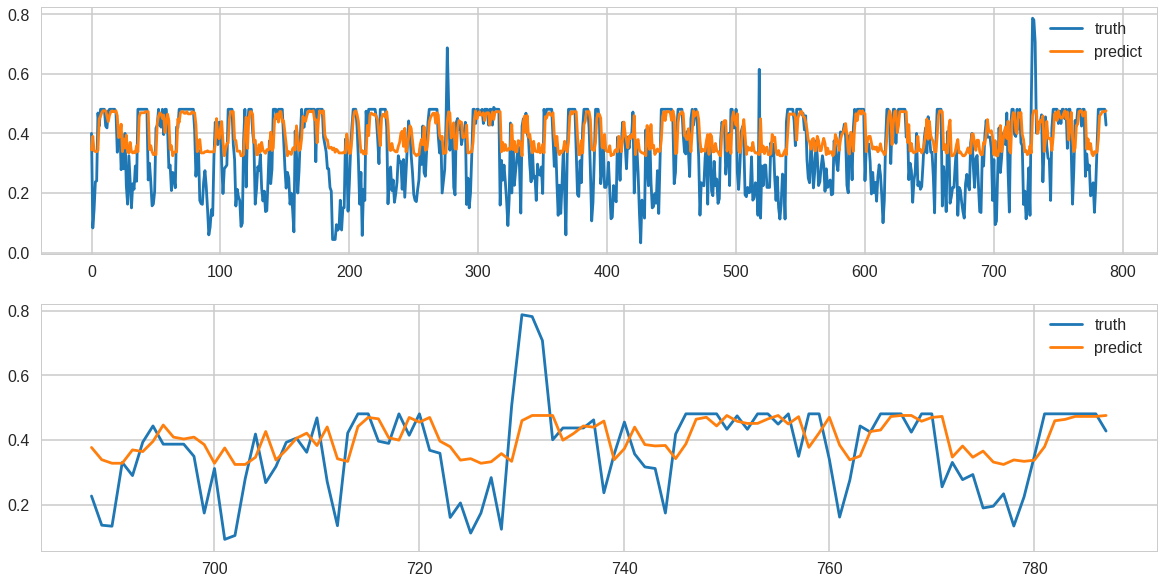

In [ ]:
# make a simple function for this, comparing truth to predictions
plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
#plt.plot(predictions[0][0:100])
plt.plot(predictions[0], label='truth')
plt.plot(predictions['xgb'], label='predict')
plt.legend()

plt.subplot(2,1,2)
plt.plot(predictions[0].tail(100), label='truth')
plt.plot(predictions['xgb'].tail(100), label='predict')
plt.legend()

In [ ]:
mean_squared_error(y_test, y_pred_xgb) 

0.01306533767220328

In [ ]:
#Root mean squared error
from sklearn.metrics import mean_squared_error
from math import sqrt
print(sqrt(mean_squared_error(y_test, y_pred_xgb)))

0.11430370804222967


In [ ]:
#mean absolute error
from sklearn.metrics import mean_absolute_error
mae=mean_absolute_error(y_test, y_pred_xgb)
print('Test MAE: %.3f' % mae)

Test MAE: 0.087


In [ ]:
#mean percentage error
mpe_sum = 0
for i,j in zip(y_test, y_pred_xgb):
    mpe_sum = mpe_sum + ((i-j)/i)
mpe = (mpe_sum/y_pred_xgb)*100

print( mpe)

[-90250.19  -79758.13  -91023.695 -91795.8   -91854.59  -90622.22
 -69371.35  -67910.734 -66225.875 -65379.457 -65379.457 -65379.457
 -67910.734 -70778.195 -67402.69  -65891.51  -65379.457 -65779.44
 -65779.44  -65379.457 -67765.75  -80589.336 -79597.04  -72183.04
 -91854.59  -81622.39  -88665.02  -78946.68  -92073.93  -93040.164
 -84139.82  -91854.59  -93040.164 -91854.59  -93040.164 -86761.016
 -91854.59  -68245.66  -66297.8   -66297.8   -66297.8   -66297.8
 -65779.44  -65779.44  -65779.44  -89954.086 -86761.016 -91922.92
 -94708.55  -93030.43  -94708.55  -71677.305 -67965.64  -66339.484
 -66958.33  -69124.664 -67412.48  -77161.45  -70824.06  -66949.945
 -70220.836 -89678.08  -86761.016 -95790.984 -92942.28  -91854.59
 -92018.664 -69390.73  -71247.195 -66225.875 -65779.44  -65779.44
 -66547.8   -66547.8   -65779.44  -66834.25  -66834.25  -66834.25
 -65779.44  -66297.8   -66297.8   -72394.89  -91854.59  -84139.82
 -81993.38  -93040.164 -93040.164 -93040.164 -91854.59  -91854.59
 -9107

In [ ]:
#r2 score
from sklearn.metrics import r2_score


r2_score(y_test, y_pred_xgb)

0.18137133358256208

In [ ]:
from sklearn.metrics import mean_absolute_error
mape = mean_absolute_error(y_test, y_pred_xgb)*100
print(mape)


8.680482772814221
